# Tally slurm total GPU hours for an account

This assumes that you have run

```bash
sacct -A pli --format=JobID,Account,AllocTRES%30,Elapsed  --allusers --json > sacct_pli.json    
```

on the server, printing out all jobs for the `pli` account.

In [63]:
%load_ext autoreload
%autoreload 2

import json
from pathlib import Path
from pandas import DataFrame as DF
import matplotlib.pyplot as plt
from slurm_analyzer import SLURMAnalyzer
import seaborn as sns
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
json_data = Path("..", 'data',  'sacct_pli_new.json')

assert json_data.exists()

In [45]:
data = json.loads(json_data.read_text())

In [46]:
df = SLURMAnalyzer().parse(data)

In [57]:
class Plot:
    def __init__(self, df: DF):
        self.df = df.copy()
        self._prepare_df()
    
    def _prepare_df(self):
        pass

In [183]:
class WaittimePlot(Plot):
    def _prepare_df(self):
        print("preparing")
        self.df = self.df.query("gpu_time >  3600")
        self.df["wait_time_h"] = self.df["wait_time"] / 3600
        self.df["gpu_time_h"] = self.df["gpu_time"] / 3600

    def hist(self, bins=20, hue="qos", **kwargs):
        # Create a figure and axis object
        fig, ax = plt.subplots()

        # Use Seaborn to create the histogram
        sns.histplot(data=self.df, x="wait_time_h", bins=bins, ax=ax, hue=hue, **kwargs)

        # Set the title and labels
        ax.set_title(f"Wait time by {hue}")
        ax.set_xlabel("Wait time [h]")
        ax.set_ylabel("Count")
    
    def boxplot_in_bins(self, var, bins):
        df = self.df

        col = f"{var}_custom_bins"
        df[col] = pd.cut(df[var], bins=bins, labels=False)
        fig, ax = plt.subplots()
        sns.boxplot(x=col, y='wait_time_h', data=df, ax=ax)

        # Set the title and labels
        ax.set_title(f"Wait Time vs {var}")
        ax.set_xlabel(f"{var}")
        ax.set_ylabel("Wait Time [h]")
        bin_labels = [ f"{a} - {b}" for a, b in zip(bins[:-1], bins[1:])]
        ax.set_xticklabels(bin_labels, rotation=45, ha='right')  # Rotate labels for better readability
    
    def plot_all(self):
        self.hist()
        self.hist(hue="partition",)
        self.boxplot_in_bins("gpu_time_h", [1, 10, 100, 500, 1000, 1e9])
        self.boxplot_in_bins("n_gpus", [0, 1, 2, 10, 16, 1e9])

preparing


/var/folders/g3/1y2_hl1j16scls01cxqm76s80000gn/T/ipykernel_88050/4222403068.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(bin_labels, rotation=45, ha='right')  # Rotate labels for better readability
/var/folders/g3/1y2_hl1j16scls01cxqm76s80000gn/T/ipykernel_88050/4222403068.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(bin_labels, rotation=45, ha='right')  # Rotate labels for better readability


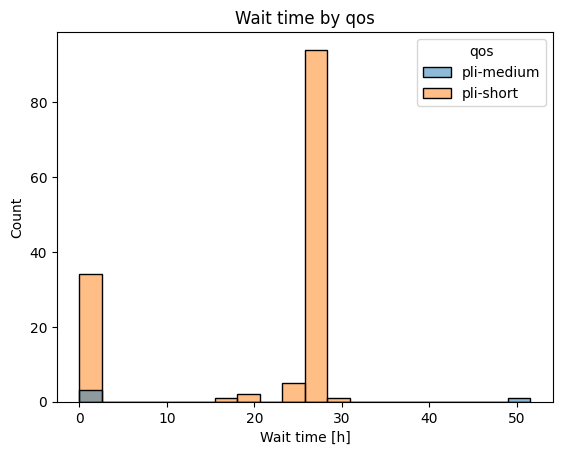

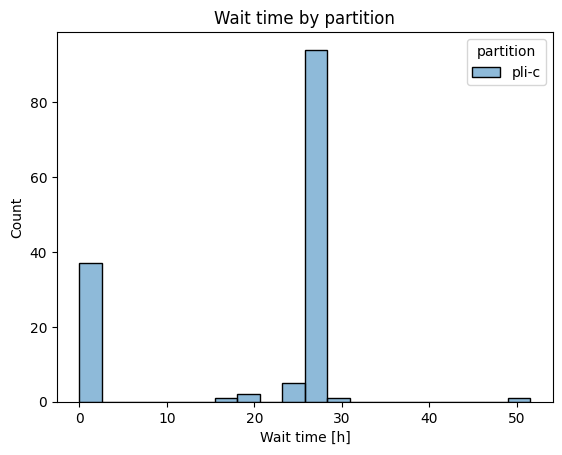

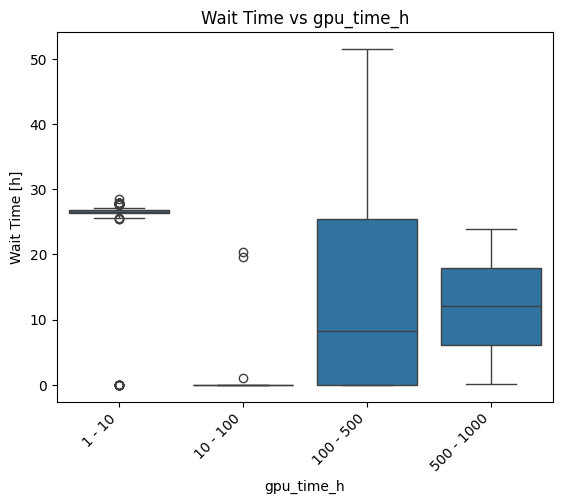

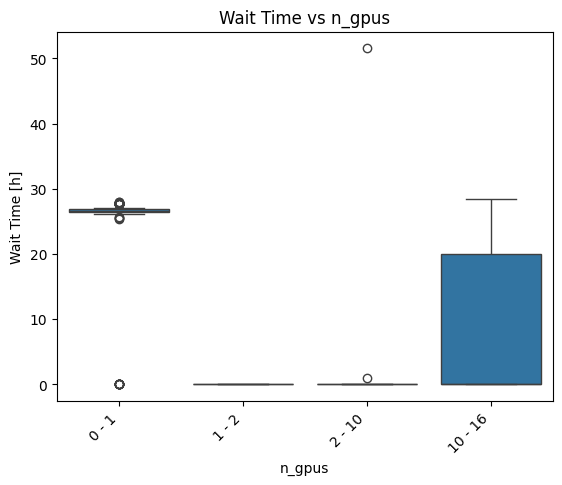

In [184]:
WaittimePlot(df).plot_all()